# EAF Notebook Definitiva

## Electric Arc Furnace - Análisis y Predicción

Notebook consolidado con código limpio, lineal y eficiente (script style).

---

## CELDA 1: Configuración Inicial

In [12]:
# =============================================================================
# IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import kagglehub
import shutil
from pathlib import Path
import warnings

warnings.filterwarnings('ignore')

# =============================================================================
# DEFINICIÓN DE RUTAS DEL PROYECTO
# =============================================================================
PROJECT_ROOT = Path.cwd()
DATA_RAW = PROJECT_ROOT / 'data' / 'raw'
DATA_PROCESSED = PROJECT_ROOT / 'data' / 'processed'
MODELS_DIR = PROJECT_ROOT / 'models'

# Crear directorios si no existen
DATA_RAW.mkdir(parents=True, exist_ok=True)
DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
MODELS_DIR.mkdir(parents=True, exist_ok=True)

print(f"PROJECT_ROOT: {PROJECT_ROOT}")
print(f"DATA_RAW: {DATA_RAW}")
print(f"DATA_PROCESSED: {DATA_PROCESSED}")
print(f"MODELS_DIR: {MODELS_DIR}")
print("\nConfiguración completada.")

PROJECT_ROOT: /Users/ibonarambarri/Desktop/indu/Industria-Entrega-Final
DATA_RAW: /Users/ibonarambarri/Desktop/indu/Industria-Entrega-Final/data/raw
DATA_PROCESSED: /Users/ibonarambarri/Desktop/indu/Industria-Entrega-Final/data/processed
MODELS_DIR: /Users/ibonarambarri/Desktop/indu/Industria-Entrega-Final/models

Configuración completada.


## CELDA 2: Descarga e Ingesta de Datos

In [6]:
# =============================================================================
# DESCARGA AUTOMÁTICA DESDE KAGGLE (si data/raw está vacía)
# =============================================================================
KAGGLE_DATASET = "yuriykatser/industrial-data-from-the-arc-furnace"

ARCHIVOS_PRINCIPALES = [
    "eaf_transformer.csv",
    "eaf_gaslance_mat.csv",
    "inj_mat.csv",
    "ladle_tapping.csv",
    "eaf_temp.csv",
    "eaf_final_chemical_measurements.csv"
]

# Verificar si la carpeta está vacía o faltan archivos
archivos_existentes = list(DATA_RAW.glob('*.csv'))
faltan_archivos = not archivos_existentes or any(
    not (DATA_RAW / f).exists() for f in ARCHIVOS_PRINCIPALES
)

if faltan_archivos:
    print(f"Descargando dataset desde Kaggle: {KAGGLE_DATASET}...")
    cached_path = Path(kagglehub.dataset_download(KAGGLE_DATASET))
    
    # Copiar archivos al directorio raw
    for archivo in cached_path.glob('*.csv'):
        shutil.copy2(archivo, DATA_RAW / archivo.name)
    
    print(f"Descarga completada. Archivos en: {DATA_RAW}")
else:
    print(f"Datos ya disponibles en: {DATA_RAW}")

print(f"Archivos CSV encontrados: {len(list(DATA_RAW.glob('*.csv')))}")

# =============================================================================
# CARGA INTELIGENTE CON LIMPIEZA AL VUELO
# =============================================================================
print("\n" + "="*60)
print("CARGANDO ARCHIVOS CSV PRINCIPALES")
print("="*60)

dataframes = {}

for archivo in ARCHIVOS_PRINCIPALES:
    filepath = DATA_RAW / archivo
    
    if not filepath.exists():
        print(f"ADVERTENCIA: {archivo} no encontrado, saltando...")
        continue
    
    # Cargar CSV
    df = pd.read_csv(filepath, low_memory=False)
    
    # Estandarizar nombres de columnas: minúsculas y sin espacios
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
    
    # Limpieza al vuelo: formato europeo de decimales (coma -> punto)
    for col in df.select_dtypes(include=['object']).columns:
        # Detectar columnas con formato europeo (ej: "123,45")
        sample = df[col].dropna().head(100).astype(str)
        if sample.str.match(r'^-?\d+,\d+$').any():
            df[col] = df[col].astype(str).str.replace(',', '.', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    
    # Nombre de variable: sin extensión y con guiones bajos
    nombre_var = archivo.replace('.csv', '').replace('-', '_')
    dataframes[nombre_var] = df
    
    print(f"  {archivo:<45} -> {df.shape[0]:>7,} filas x {df.shape[1]:>3} cols")

# =============================================================================
# ASIGNAR A VARIABLES INDIVIDUALES PARA FACILITAR USO
# =============================================================================
df_transformer = dataframes.get('eaf_transformer')
df_gaslance = dataframes.get('eaf_gaslance_mat')
df_injection = dataframes.get('inj_mat')
df_ladle = dataframes.get('ladle_tapping')
df_temp = dataframes.get('eaf_temp')
df_chemical = dataframes.get('eaf_final_chemical_measurements')

print("\n" + "="*60)
print("INGESTA COMPLETADA")
print("="*60)
print(f"DataFrames cargados: {list(dataframes.keys())}")
print("\nVariables disponibles:")
print("  - df_transformer  : Datos del transformador eléctrico")
print("  - df_gaslance     : Datos de lanza de gas/oxígeno")
print("  - df_injection    : Datos de inyección de materiales")
print("  - df_ladle        : Datos de cuchara (tapping)")
print("  - df_temp         : Mediciones de temperatura")
print("  - df_chemical     : Mediciones químicas finales")

Datos ya disponibles en: /Users/ibonarambarri/Desktop/indu/Industria-Entrega-Final/data/raw
Archivos CSV encontrados: 11

CARGANDO ARCHIVOS CSV PRINCIPALES
  eaf_transformer.csv                           -> 271,712 filas x   5 cols
  eaf_gaslance_mat.csv                          -> 5,748,194 filas x   6 cols
  inj_mat.csv                                   -> 4,011,646 filas x   4 cols
  ladle_tapping.csv                             -> 115,873 filas x   5 cols
  eaf_temp.csv                                  ->  85,104 filas x   4 cols
  eaf_final_chemical_measurements.csv           ->   3,709 filas x  15 cols

INGESTA COMPLETADA
DataFrames cargados: ['eaf_transformer', 'eaf_gaslance_mat', 'inj_mat', 'ladle_tapping', 'eaf_temp', 'eaf_final_chemical_measurements']

Variables disponibles:
  - df_transformer  : Datos del transformador eléctrico
  - df_gaslance     : Datos de lanza de gas/oxígeno
  - df_injection    : Datos de inyección de materiales
  - df_ladle        : Datos de cuchara (t

## CELDA 3: Feature Engineering

Generación de datasets procesados:
- **df_master**: Variables estáticas agregadas por colada (heatid)
- **dataset_temperature.csv**: Dataset secuencial para predicción de temperatura
- **dataset_chemical.csv**: Dataset estático para predicción de composición química

In [14]:
# =============================================================================
# 1. DATASET MAESTRO - VARIABLES ESTÁTICAS POR COLADA
# =============================================================================
print("="*60)
print("CONSTRUYENDO DATASET MAESTRO (VARIABLES ESTÁTICAS)")
print("="*60)

# -----------------------------------------------------------------------------
# 1.1 Energía del transformador (mw * duración en minutos)
# -----------------------------------------------------------------------------
df_trans = df_transformer.copy()

# Parsear duración "MM:SS" a minutos
df_trans['duration_min'] = df_trans['duration'].apply(
    lambda x: float(str(x).split(':')[0]) + float(str(x).split(':')[1])/60 
    if pd.notna(x) and ':' in str(x) else 0
)
df_trans['mw'] = pd.to_numeric(df_trans['mw'], errors='coerce').fillna(0)
df_trans['energy_mwh'] = df_trans['mw'] * df_trans['duration_min'] / 60

grp_energy = df_trans.groupby('heatid').agg(
    total_energy=('energy_mwh', 'sum'),
    total_duration_min=('duration_min', 'sum')
).reset_index()

print(f"  Energía agregada: {len(grp_energy)} coladas")

# -----------------------------------------------------------------------------
# 1.2 Gases (O2 y gas) - último valor acumulado por colada
# -----------------------------------------------------------------------------
df_gas = df_gaslance.copy()
df_gas['o2_amount'] = pd.to_numeric(df_gas['o2_amount'], errors='coerce')
df_gas['gas_amount'] = pd.to_numeric(df_gas['gas_amount'], errors='coerce')

# Detectar columna de tiempo
col_time_gas = [c for c in df_gas.columns if 'time' in c.lower()][0]
df_gas[col_time_gas] = pd.to_datetime(df_gas[col_time_gas].astype(str).str.replace(',', '.'), errors='coerce')
df_gas = df_gas.sort_values(['heatid', col_time_gas])

grp_gas = df_gas.groupby('heatid').agg(
    total_o2=('o2_amount', 'last'),
    total_gas=('gas_amount', 'last')
).reset_index()

print(f"  Gases agregados: {len(grp_gas)} coladas")

# -----------------------------------------------------------------------------
# 1.3 Inyección de carbón - último valor acumulado
# -----------------------------------------------------------------------------
df_inj = df_injection.copy()
df_inj['inj_amount_carbon'] = pd.to_numeric(df_inj['inj_amount_carbon'], errors='coerce')

col_time_inj = [c for c in df_inj.columns if 'time' in c.lower()][0]
df_inj[col_time_inj] = pd.to_datetime(df_inj[col_time_inj].astype(str).str.replace(',', '.'), errors='coerce')
df_inj = df_inj.sort_values(['heatid', col_time_inj])

grp_carbon = df_inj.groupby('heatid').agg(
    total_carbon=('inj_amount_carbon', 'last')
).reset_index()

print(f"  Carbón agregado: {len(grp_carbon)} coladas")

# -----------------------------------------------------------------------------
# 1.4 Materiales (ladle) - carga total + pivot top 10 materiales
# -----------------------------------------------------------------------------
df_mat = df_ladle.copy()
df_mat['charge_amount'] = pd.to_numeric(df_mat['charge_amount'], errors='coerce').fillna(0)

# Carga total por colada
grp_charge = df_mat.groupby('heatid').agg(
    total_charge=('charge_amount', 'sum')
).reset_index()

# Pivot: top 10 materiales más frecuentes
top_10_materials = df_mat['mat_code'].value_counts().head(10).index.tolist()
df_mat_top = df_mat[df_mat['mat_code'].isin(top_10_materials)]

pivot_materials = df_mat_top.pivot_table(
    index='heatid',
    columns='mat_code',
    values='charge_amount',
    aggfunc='sum',
    fill_value=0
).add_prefix('mat_').reset_index()

print(f"  Materiales: {len(grp_charge)} coladas, {len(top_10_materials)} tipos pivotados")

# -----------------------------------------------------------------------------
# 1.5 Fusión en df_master
# -----------------------------------------------------------------------------
# Base: todos los heatids únicos
all_heatids = set(grp_energy['heatid']) | set(grp_gas['heatid']) | set(grp_carbon['heatid'])
df_master = pd.DataFrame({'heatid': list(all_heatids)})

# Merge secuencial
df_master = df_master.merge(grp_energy, on='heatid', how='left')
df_master = df_master.merge(grp_gas, on='heatid', how='left')
df_master = df_master.merge(grp_carbon, on='heatid', how='left')
df_master = df_master.merge(grp_charge, on='heatid', how='left')
df_master = df_master.merge(pivot_materials, on='heatid', how='left')

# Rellenar nulos con 0
df_master = df_master.fillna(0)

print(f"\n  df_master: {df_master.shape[0]} coladas x {df_master.shape[1]} features")
print(f"  Columnas: {df_master.columns.tolist()}")

# =============================================================================
# 2. DATASET SECUENCIAL - TEMPERATURA
# =============================================================================
print("\n" + "="*60)
print("CONSTRUYENDO DATASET SECUENCIAL (TEMPERATURA)")
print("="*60)

df_t = df_temp.copy()

# Detectar columnas
col_temp = [c for c in df_t.columns if 'temp' in c.lower() and 'time' not in c.lower()][0]
col_time = [c for c in df_t.columns if 'time' in c.lower() or 'date' in c.lower()][0]
col_ox = [c for c in df_t.columns if 'ox' in c.lower()]
col_ox = col_ox[0] if col_ox else None

print(f"  Columna temperatura: {col_temp}")
print(f"  Columna tiempo: {col_time}")

# Convertir tipos
df_t[col_temp] = pd.to_numeric(df_t[col_temp], errors='coerce')
df_t[col_time] = pd.to_datetime(df_t[col_time].astype(str).str.replace(',', '.'), errors='coerce')
if col_ox:
    df_t[col_ox] = pd.to_numeric(df_t[col_ox], errors='coerce')

# Filtrar rango válido (1000-1850 °C)
n_inicial = len(df_t)
df_t = df_t[(df_t[col_temp] >= 1000) & (df_t[col_temp] <= 1850)].copy()
print(f"  Filtro 1000-1850°C: {n_inicial:,} -> {len(df_t):,} filas")

# Eliminar nulos y ordenar
df_t = df_t.dropna(subset=['heatid', col_time, col_temp])
df_t = df_t.sort_values(['heatid', col_time]).reset_index(drop=True)

# Features secuenciales
df_t['temp_actual'] = df_t[col_temp]
df_t['oxidation'] = df_t[col_ox].fillna(0) if col_ox else 0
df_t['num_measurement'] = df_t.groupby('heatid').cumcount() + 1
df_t['time_since_start'] = df_t.groupby('heatid')[col_time].transform(
    lambda x: (x - x.min()).dt.total_seconds() / 60
)

# Target: temperatura siguiente (shift -1 dentro de cada colada)
df_t['target_next_temp'] = df_t.groupby('heatid')[col_temp].shift(-1)
df_t['datetime_next'] = df_t.groupby('heatid')[col_time].shift(-1)
df_t['horizon_min'] = (df_t['datetime_next'] - df_t[col_time]).dt.total_seconds() / 60

# Limpiar bordes (última medición de cada colada no tiene target)
df_t = df_t.dropna(subset=['target_next_temp'])
df_t = df_t[(df_t['horizon_min'] > 0) & (df_t['horizon_min'] < 120)]

print(f"  Filas con target válido: {len(df_t):,}")

# Fusionar con df_master
df_temp_final = df_t.merge(df_master, on='heatid', how='left').fillna(0)

# Seleccionar columnas finales (eliminar auxiliares)
cols_drop = [col_temp, col_time, 'datetime_next']
if col_ox and col_ox in df_temp_final.columns:
    cols_drop.append(col_ox)
df_temp_final = df_temp_final.drop(columns=[c for c in cols_drop if c in df_temp_final.columns])

# Guardar
df_temp_final.to_csv(DATA_PROCESSED / 'dataset_temperature.csv', index=False)
print(f"\n  Guardado: dataset_temperature.csv")
print(f"  Shape: {df_temp_final.shape}")

# =============================================================================
# 3. DATASET ESTÁTICO - QUÍMICA
# =============================================================================
print("\n" + "="*60)
print("CONSTRUYENDO DATASET ESTÁTICO (QUÍMICA)")
print("="*60)

df_chem = df_chemical.copy()

# Extraer columnas target (empiezan por 'val')
target_cols = [c for c in df_chem.columns if c.startswith('val')]
print(f"  Targets químicos encontrados: {target_cols}")

# Convertir a numérico
for col in target_cols:
    df_chem[col] = pd.to_numeric(df_chem[col], errors='coerce')

# Seleccionar heatid + targets, eliminar duplicados
df_targets = df_chem[['heatid'] + target_cols].drop_duplicates(subset=['heatid'], keep='last')

# Renombrar con prefijo target_
df_targets = df_targets.rename(columns={c: f'target_{c}' for c in target_cols})

# -----------------------------------------------------------------------------
# CARGAR MEDICIONES QUÍMICAS INICIALES
# -----------------------------------------------------------------------------
print("\n  Cargando mediciones químicas iniciales...")
df_chem_inicial = pd.read_csv(DATA_RAW / 'lf_initial_chemical_measurements.csv', low_memory=False)
df_chem_inicial.columns = df_chem_inicial.columns.str.lower().str.strip()

# Columnas de valores iniciales
init_cols = ['valc', 'valsi', 'valmn', 'valp', 'vals', 'valcu', 'valcr', 'valmo', 'valni']

# Convertir a numérico (formato europeo coma -> punto)
for col in init_cols:
    if col in df_chem_inicial.columns:
        df_chem_inicial[col] = df_chem_inicial[col].astype(str).str.replace(',', '.', regex=False)
        df_chem_inicial[col] = pd.to_numeric(df_chem_inicial[col], errors='coerce')

# Tomar primera medición por colada y renombrar con prefijo init_
df_init = df_chem_inicial.groupby('heatid')[init_cols].first().reset_index()
df_init = df_init.rename(columns={c: f'init_{c}' for c in init_cols})

print(f"  Valores iniciales: {len(df_init)} coladas, {len(init_cols)} elementos")

# -----------------------------------------------------------------------------
# LIMPIEZA DE OUTLIERS EN TARGETS QUÍMICOS (CRÍTICO)
# -----------------------------------------------------------------------------
print("\n  Limpieza de outliers:")
target_renamed = [f'target_{c}' for c in target_cols]

for col in target_renamed:
    # 1. Reemplazar valores centinela (>=100 es imposible para % químico)
    mask_centinela = df_targets[col] >= 100
    n_centinela = mask_centinela.sum()
    if n_centinela > 0:
        df_targets.loc[mask_centinela, col] = np.nan
        print(f"    {col}: {n_centinela} valores centinela (>=100) -> NaN")
    
    # 2. Filtrar outliers extremos (> percentil 99.5)
    p995 = df_targets[col].quantile(0.995)
    if p995 > 0 and p995 < 10:  # Solo si tiene sentido
        mask_outlier = df_targets[col] > p995 * 3  # 3x el P99.5
        n_outlier = mask_outlier.sum()
        if n_outlier > 0:
            df_targets.loc[mask_outlier, col] = np.nan
            print(f"    {col}: {n_outlier} outliers extremos -> NaN")

# Fusionar con df_master (inner join: solo coladas con datos completos)
df_chem_final = df_master.merge(df_targets, on='heatid', how='inner')

# Fusionar con valores iniciales
df_chem_final = df_chem_final.merge(df_init, on='heatid', how='left')

# Rellenar NaN con 0 SOLO en features, no en targets
feature_cols_chem = [c for c in df_chem_final.columns if not c.startswith('target_') and c != 'heatid']
df_chem_final[feature_cols_chem] = df_chem_final[feature_cols_chem].fillna(0)

# Guardar
df_chem_final.to_csv(DATA_PROCESSED / 'dataset_chemical.csv', index=False)
print(f"\n  Guardado: dataset_chemical.csv")
print(f"  Shape: {df_chem_final.shape}")

# Verificación de targets limpios
print("\n  Verificación de targets (después de limpieza):")
for col in target_renamed[:3]:  # Mostrar solo los primeros 3
    data = df_chem_final[col].dropna()
    print(f"    {col}: mean={data.mean():.4f}, std={data.std():.4f}, max={data.max():.4f}")

# Verificación de valores iniciales
print("\n  Valores iniciales añadidos:")
init_renamed = [f'init_{c}' for c in init_cols]
print(f"    Columnas: {init_renamed}")

# =============================================================================
# RESUMEN FINAL
# =============================================================================
print("\n" + "="*60)
print("FEATURE ENGINEERING COMPLETADO")
print("="*60)
print(f"  df_master:            {df_master.shape[0]:>6,} coladas x {df_master.shape[1]:>3} features")
print(f"  dataset_temperature:  {df_temp_final.shape[0]:>6,} filas   x {df_temp_final.shape[1]:>3} features")
print(f"  dataset_chemical:     {df_chem_final.shape[0]:>6,} coladas x {df_chem_final.shape[1]:>3} features")
print(f"\nArchivos guardados en: {DATA_PROCESSED}")

CONSTRUYENDO DATASET MAESTRO (VARIABLES ESTÁTICAS)
  Energía agregada: 20813 coladas
  Gases agregados: 20827 coladas
  Carbón agregado: 20827 coladas
  Materiales: 20827 coladas, 10 tipos pivotados

  df_master: 20827 coladas x 17 features
  Columnas: ['heatid', 'total_energy', 'total_duration_min', 'total_o2', 'total_gas', 'total_carbon', 'total_charge', 'mat_140107', 'mat_202007', 'mat_202008', 'mat_202039', 'mat_202063', 'mat_203068', 'mat_203085', 'mat_205069', 'mat_360258', 'mat_705043']

CONSTRUYENDO DATASET SECUENCIAL (TEMPERATURA)
  Columna temperatura: temp
  Columna tiempo: datetime
  Filtro 1000-1850°C: 85,104 -> 85,104 filas
  Filas con target válido: 59,714

  Guardado: dataset_temperature.csv
  Shape: (59714, 24)

CONSTRUYENDO DATASET ESTÁTICO (QUÍMICA)
  Targets químicos encontrados: ['valc', 'valsi', 'valmn', 'valp', 'vals', 'valcu', 'valcr', 'valmo', 'valni', 'valas', 'valsn', 'valn']

  Cargando mediciones químicas iniciales...
  Valores iniciales: 20827 coladas, 9 e

## CELDA 4: Modelo de Predicción de Temperatura

Entrenamiento de XGBoost para predecir la temperatura del siguiente paso temporal.

**Aspectos clave:**
- **GroupShuffleSplit**: Evita data leakage manteniendo todas las mediciones de una colada en el mismo split
- **Target**: `target_next_temp` (temperatura del siguiente registro)
- **Métricas**: RMSE y R²

In [17]:
# =============================================================================
# MODELO DE PREDICCIÓN DE TEMPERATURA - XGBoost
# =============================================================================
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import joblib

print("="*60)
print("MODELO DE TEMPERATURA - XGBOOST")
print("="*60)

# -----------------------------------------------------------------------------
# 1. CARGA DEL DATASET
# -----------------------------------------------------------------------------
df_temp_model = pd.read_csv(DATA_PROCESSED / 'dataset_temperature.csv')
print(f"Dataset cargado: {df_temp_model.shape}")

# -----------------------------------------------------------------------------
# 2. LIMPIEZA FINAL
# -----------------------------------------------------------------------------
n_inicial = len(df_temp_model)

# Eliminar filas con target nulo
df_temp_model = df_temp_model.dropna(subset=['target_next_temp'])

# Filtrar horizonte temporal anómalo (> 120 min)
if 'horizon_min' in df_temp_model.columns:
    df_temp_model = df_temp_model[
        (df_temp_model['horizon_min'] > 0) & 
        (df_temp_model['horizon_min'] <= 120)
    ]

print(f"Limpieza: {n_inicial:,} -> {len(df_temp_model):,} filas")

# -----------------------------------------------------------------------------
# 3. PREPARACIÓN DE FEATURES Y TARGET
# -----------------------------------------------------------------------------
TARGET = 'target_next_temp'

# =============================================================================
# LISTA EDITABLE DE FEATURES - Modifica esta lista para cambiar las variables
# =============================================================================
FEATURES_TEMPERATURA = [
    'temp_actual',
    'oxidation',
    'num_measurement',
    'time_since_start',
    'horizon_min',
    'total_energy',
    'total_duration_min',
    'total_o2',
    'total_gas',
    'total_carbon',
    'total_charge',
    'mat_140107',
    'mat_202007',
    'mat_202008',
    'mat_202039',
    'mat_202063',
    'mat_203068',
    'mat_203085',
    'mat_205069',
    'mat_360258',
    'mat_705043',
]

X = df_temp_model[FEATURES_TEMPERATURA]
y = df_temp_model[TARGET]
groups = df_temp_model['heatid']

print(f"\nFeatures: {len(FEATURES_TEMPERATURA)}")
print(f"  {FEATURES_TEMPERATURA}")
print(f"Muestras: {len(X):,}")
print(f"Coladas únicas: {groups.nunique()}")

# -----------------------------------------------------------------------------
# 4. SPLIT TRAIN/TEST CON GROUPSHUFFLESPLIT (CRÍTICO)
# -----------------------------------------------------------------------------
# GroupShuffleSplit garantiza que todas las mediciones de una misma colada
# estén completamente en train O en test, nunca mezcladas.
# Esto evita DATA LEAKAGE temporal.

TEST_SIZE = 0.2
RANDOM_STATE = 42

gss = GroupShuffleSplit(n_splits=1, test_size=TEST_SIZE, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups))

X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

# Verificar que no hay coladas mezcladas
train_heats = set(groups.iloc[train_idx])
test_heats = set(groups.iloc[test_idx])
overlap = train_heats & test_heats

print(f"\nSplit Train/Test (GroupShuffleSplit):")
print(f"  Train: {len(X_train):>7,} muestras ({len(train_heats):,} coladas)")
print(f"  Test:  {len(X_test):>7,} muestras ({len(test_heats):,} coladas)")
print(f"  Coladas superpuestas: {len(overlap)} (debe ser 0)")

if len(overlap) > 0:
    print("  ADVERTENCIA: Data leakage detectado!")
else:
    print("  Sin data leakage por coladas mezcladas")

# -----------------------------------------------------------------------------
# 5. ENTRENAMIENTO DEL MODELO XGBOOST
# -----------------------------------------------------------------------------
HYPERPARAMS = {
    'n_estimators': 200,
    'max_depth': 6,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': RANDOM_STATE,
    'n_jobs': -1
}

print(f"\nEntrenando XGBRegressor...")
print(f"Hiperparámetros: {HYPERPARAMS}")

model_temp = XGBRegressor(**HYPERPARAMS)
model_temp.fit(X_train, y_train)

print("Entrenamiento completado.")

# -----------------------------------------------------------------------------
# 6. PREDICCIÓN Y EVALUACIÓN
# -----------------------------------------------------------------------------
# Predicciones en train y test
y_pred_train = model_temp.predict(X_train)
y_pred_test = model_temp.predict(X_test)

# Métricas en TRAIN
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
r2_train = r2_score(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)

# Métricas en TEST
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_test = r2_score(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)

print("\n" + "="*60)
print("MÉTRICAS DE EVALUACIÓN")
print("="*60)
print(f"{'Métrica':<10} {'Train':>12} {'Test':>12}")
print("-"*36)
print(f"{'RMSE':<10} {rmse_train:>10.2f} °C {rmse_test:>10.2f} °C")
print(f"{'MAE':<10} {mae_train:>10.2f} °C {mae_test:>10.2f} °C")
print(f"{'R²':<10} {r2_train:>12.4f} {r2_test:>12.4f}")
print("="*60)

# Interpretación
print(f"\nR² Test: {r2_test:.4f}")
if r2_test > 0.8:
    print("Excelente capacidad predictiva.")
elif r2_test > 0.6:
    print("Buena capacidad predictiva.")
elif r2_test > 0.3:
    print("Capacidad predictiva moderada.")
else:
    print("Capacidad predictiva baja. Revisar features o hiperparámetros.")

# Detectar overfitting
if r2_train - r2_test > 0.15:
    print(f"\nADVERTENCIA: Posible overfitting (R² train - R² test = {r2_train - r2_test:.4f})")

# -----------------------------------------------------------------------------
# 7. GUARDAR MODELO
# -----------------------------------------------------------------------------
model_path = MODELS_DIR / 'model_temperature_xgboost.joblib'
joblib.dump(model_temp, model_path)
print(f"\nModelo guardado: {model_path}")

MODELO DE TEMPERATURA - XGBOOST
Dataset cargado: (59714, 24)
Limpieza: 59,714 -> 59,714 filas

Features: 21
  ['temp_actual', 'oxidation', 'num_measurement', 'time_since_start', 'horizon_min', 'total_energy', 'total_duration_min', 'total_o2', 'total_gas', 'total_carbon', 'total_charge', 'mat_140107', 'mat_202007', 'mat_202008', 'mat_202039', 'mat_202063', 'mat_203068', 'mat_203085', 'mat_205069', 'mat_360258', 'mat_705043']
Muestras: 59,714
Coladas únicas: 19556

Split Train/Test (GroupShuffleSplit):
  Train:  47,769 muestras (15,644 coladas)
  Test:   11,945 muestras (3,912 coladas)
  Coladas superpuestas: 0 (debe ser 0)
  Sin data leakage por coladas mezcladas

Entrenando XGBRegressor...
Hiperparámetros: {'n_estimators': 200, 'max_depth': 6, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.8, 'random_state': 42, 'n_jobs': -1}
Entrenamiento completado.

MÉTRICAS DE EVALUACIÓN
Métrica           Train         Test
------------------------------------
RMSE            16.42 °

## CELDA 5: Modelo de Predicción Química (Carbono)

Predicción de la composición química final del acero (ejemplo: Carbono).

**Aspectos clave:**
- **Target**: `target_valc` (% de Carbono final)
- **Features**: Variables del proceso (energía, materiales, gases)
- **Exclusión**: Se excluyen TODOS los targets químicos para evitar data leakage

MODELO QUÍMICO - AZUFRE (S)
Dataset cargado: (3709, 38)

Features utilizadas: 11
  ['total_o2', 'total_gas', 'total_carbon', 'init_valc', 'init_valsi', 'init_valmn', 'init_valp', 'init_vals', 'init_valcu', 'init_valcr', 'init_valmo']

Muestras: 3341
Target (target_vals): media=0.0334, std=0.0117

Split Train/Test:
  Train: 2672 muestras
  Test:  669 muestras

Entrenando XGBRegressor para Azufre...
Entrenamiento completado.

MÉTRICAS - AZUFRE (S)
  RMSE:  0.007043
  MAE:   0.005245
  R²:    0.6068


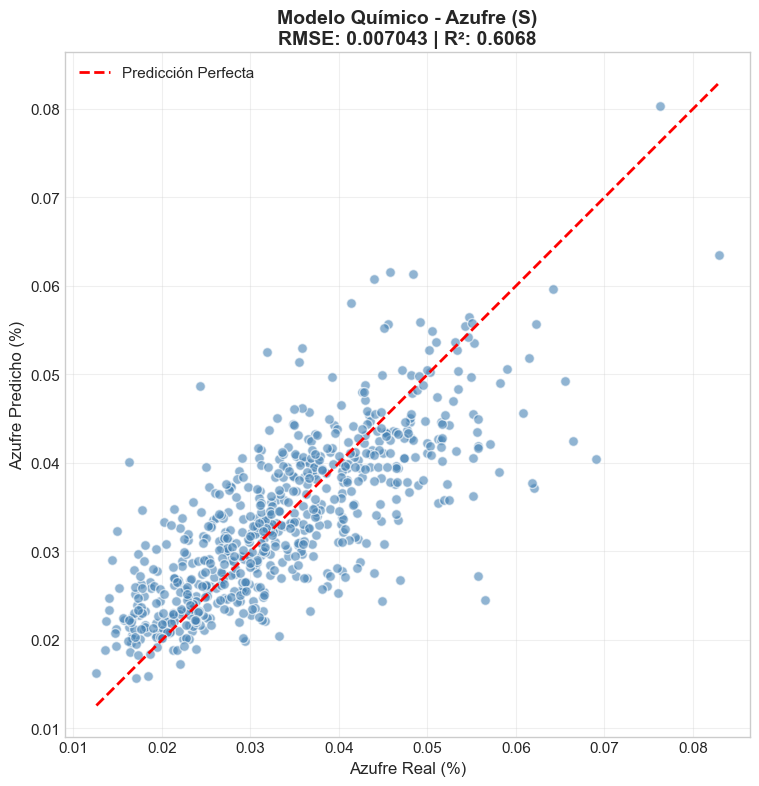


Modelo guardado: /Users/ibonarambarri/Desktop/indu/Industria-Entrega-Final/models/model_chemical_sulfur_xgboost.joblib


In [ ]:
# =============================================================================
# MODELO DE PREDICCIÓN QUÍMICA - AZUFRE (XGBoost)
# =============================================================================
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from xgboost import XGBRegressor
import joblib

print("="*60)
print("MODELO QUÍMICO - AZUFRE (S)")
print("="*60)

# -----------------------------------------------------------------------------
# 1. CARGA DEL DATASET
# -----------------------------------------------------------------------------
df_chem_model = pd.read_csv(DATA_PROCESSED / 'dataset_chemical.csv')
print(f"Dataset cargado: {df_chem_model.shape}")

# -----------------------------------------------------------------------------
# 2. DEFINICIÓN DEL TARGET
# -----------------------------------------------------------------------------
TARGET_CHEM = 'target_vals'  # Azufre (S)

# =============================================================================
# LISTA EDITABLE DE FEATURES - Modifica esta lista para cambiar las variables
# =============================================================================
FEATURES_QUIMICO = [
    # Variables del proceso
    'total_energy',
    'total_duration_min',
    'total_o2',
    'total_gas',
    'total_carbon',
    'total_charge',
    'mat_140107',
    'mat_202007',
    'mat_202008',
    'mat_202039',
    'mat_202063',
    'mat_203068',
    'mat_203085',
    'mat_205069',
    'mat_360258',
    'mat_705043',
    # Valores químicos iniciales
    'init_valc',
    'init_valsi',
    'init_valmn',
    'init_valp',
    'init_vals',
    'init_valcu',
    'init_valcr',
    'init_valmo',
    'init_valni',
]

print(f"\nFeatures utilizadas: {len(FEATURES_QUIMICO)}")
print(f"  {FEATURES_QUIMICO}")

# -----------------------------------------------------------------------------
# 3. PREPARACIÓN DE DATOS
# -----------------------------------------------------------------------------
# Eliminar filas donde el target es nulo
df_chem_model = df_chem_model.dropna(subset=[TARGET_CHEM])

X_chem = df_chem_model[FEATURES_QUIMICO].fillna(0)
y_chem = df_chem_model[TARGET_CHEM]

print(f"\nMuestras: {len(X_chem)}")
print(f"Target ({TARGET_CHEM}): media={y_chem.mean():.4f}, std={y_chem.std():.4f}")

# -----------------------------------------------------------------------------
# 4. SPLIT TRAIN/TEST
# -----------------------------------------------------------------------------
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_chem, y_chem, 
    test_size=0.2, 
    random_state=42
)

print(f"\nSplit Train/Test:")
print(f"  Train: {len(X_train_c)} muestras")
print(f"  Test:  {len(X_test_c)} muestras")

# -----------------------------------------------------------------------------
# 5. ENTRENAMIENTO
# -----------------------------------------------------------------------------
HYPERPARAMS_CHEM = {
    'n_estimators': 150,
    'max_depth': 5,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'random_state': 42,
    'n_jobs': -1
}

print(f"\nEntrenando XGBRegressor para Azufre...")
model_sulfur = XGBRegressor(**HYPERPARAMS_CHEM)
model_sulfur.fit(X_train_c, y_train_c)
print("Entrenamiento completado.")

# -----------------------------------------------------------------------------
# 6. PREDICCIÓN Y MÉTRICAS
# -----------------------------------------------------------------------------
y_pred_c = model_sulfur.predict(X_test_c)

rmse_c = np.sqrt(mean_squared_error(y_test_c, y_pred_c))
r2_c = r2_score(y_test_c, y_pred_c)
mae_c = mean_absolute_error(y_test_c, y_pred_c)

print("\n" + "="*60)
print("MÉTRICAS - AZUFRE (S)")
print("="*60)
print(f"  RMSE:  {rmse_c:.6f}")
print(f"  MAE:   {mae_c:.6f}")
print(f"  R²:    {r2_c:.4f}")
print("="*60)

# -----------------------------------------------------------------------------
# 7. VISUALIZACIÓN: VALORES REALES VS PREDICHOS
# -----------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(8, 8))

# Scatter plot
ax.scatter(y_test_c, y_pred_c, alpha=0.6, c='steelblue', edgecolors='white', s=50)

# Línea de predicción perfecta (diagonal)
lims = [
    min(y_test_c.min(), y_pred_c.min()),
    max(y_test_c.max(), y_pred_c.max())
]
ax.plot(lims, lims, 'r--', linewidth=2, label='Predicción Perfecta')

# Configuración
ax.set_xlabel('Azufre Real (%)', fontsize=12)
ax.set_ylabel('Azufre Predicho (%)', fontsize=12)
ax.set_title(f'Modelo Químico - Azufre (S)\nRMSE: {rmse_c:.6f} | R²: {r2_c:.4f}', 
             fontsize=14, fontweight='bold')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

plt.tight_layout()
plt.show()

# -----------------------------------------------------------------------------
# 8. GUARDAR MODELO
# -----------------------------------------------------------------------------
model_path_s = MODELS_DIR / 'model_chemical_sulfur_xgboost.joblib'
joblib.dump(model_sulfur, model_path_s)
print(f"\nModelo guardado: {model_path_s}")